# Chapter 2: Risk Metrics #

Code segment 2.1  
Figure 2.1 in Section 2.2

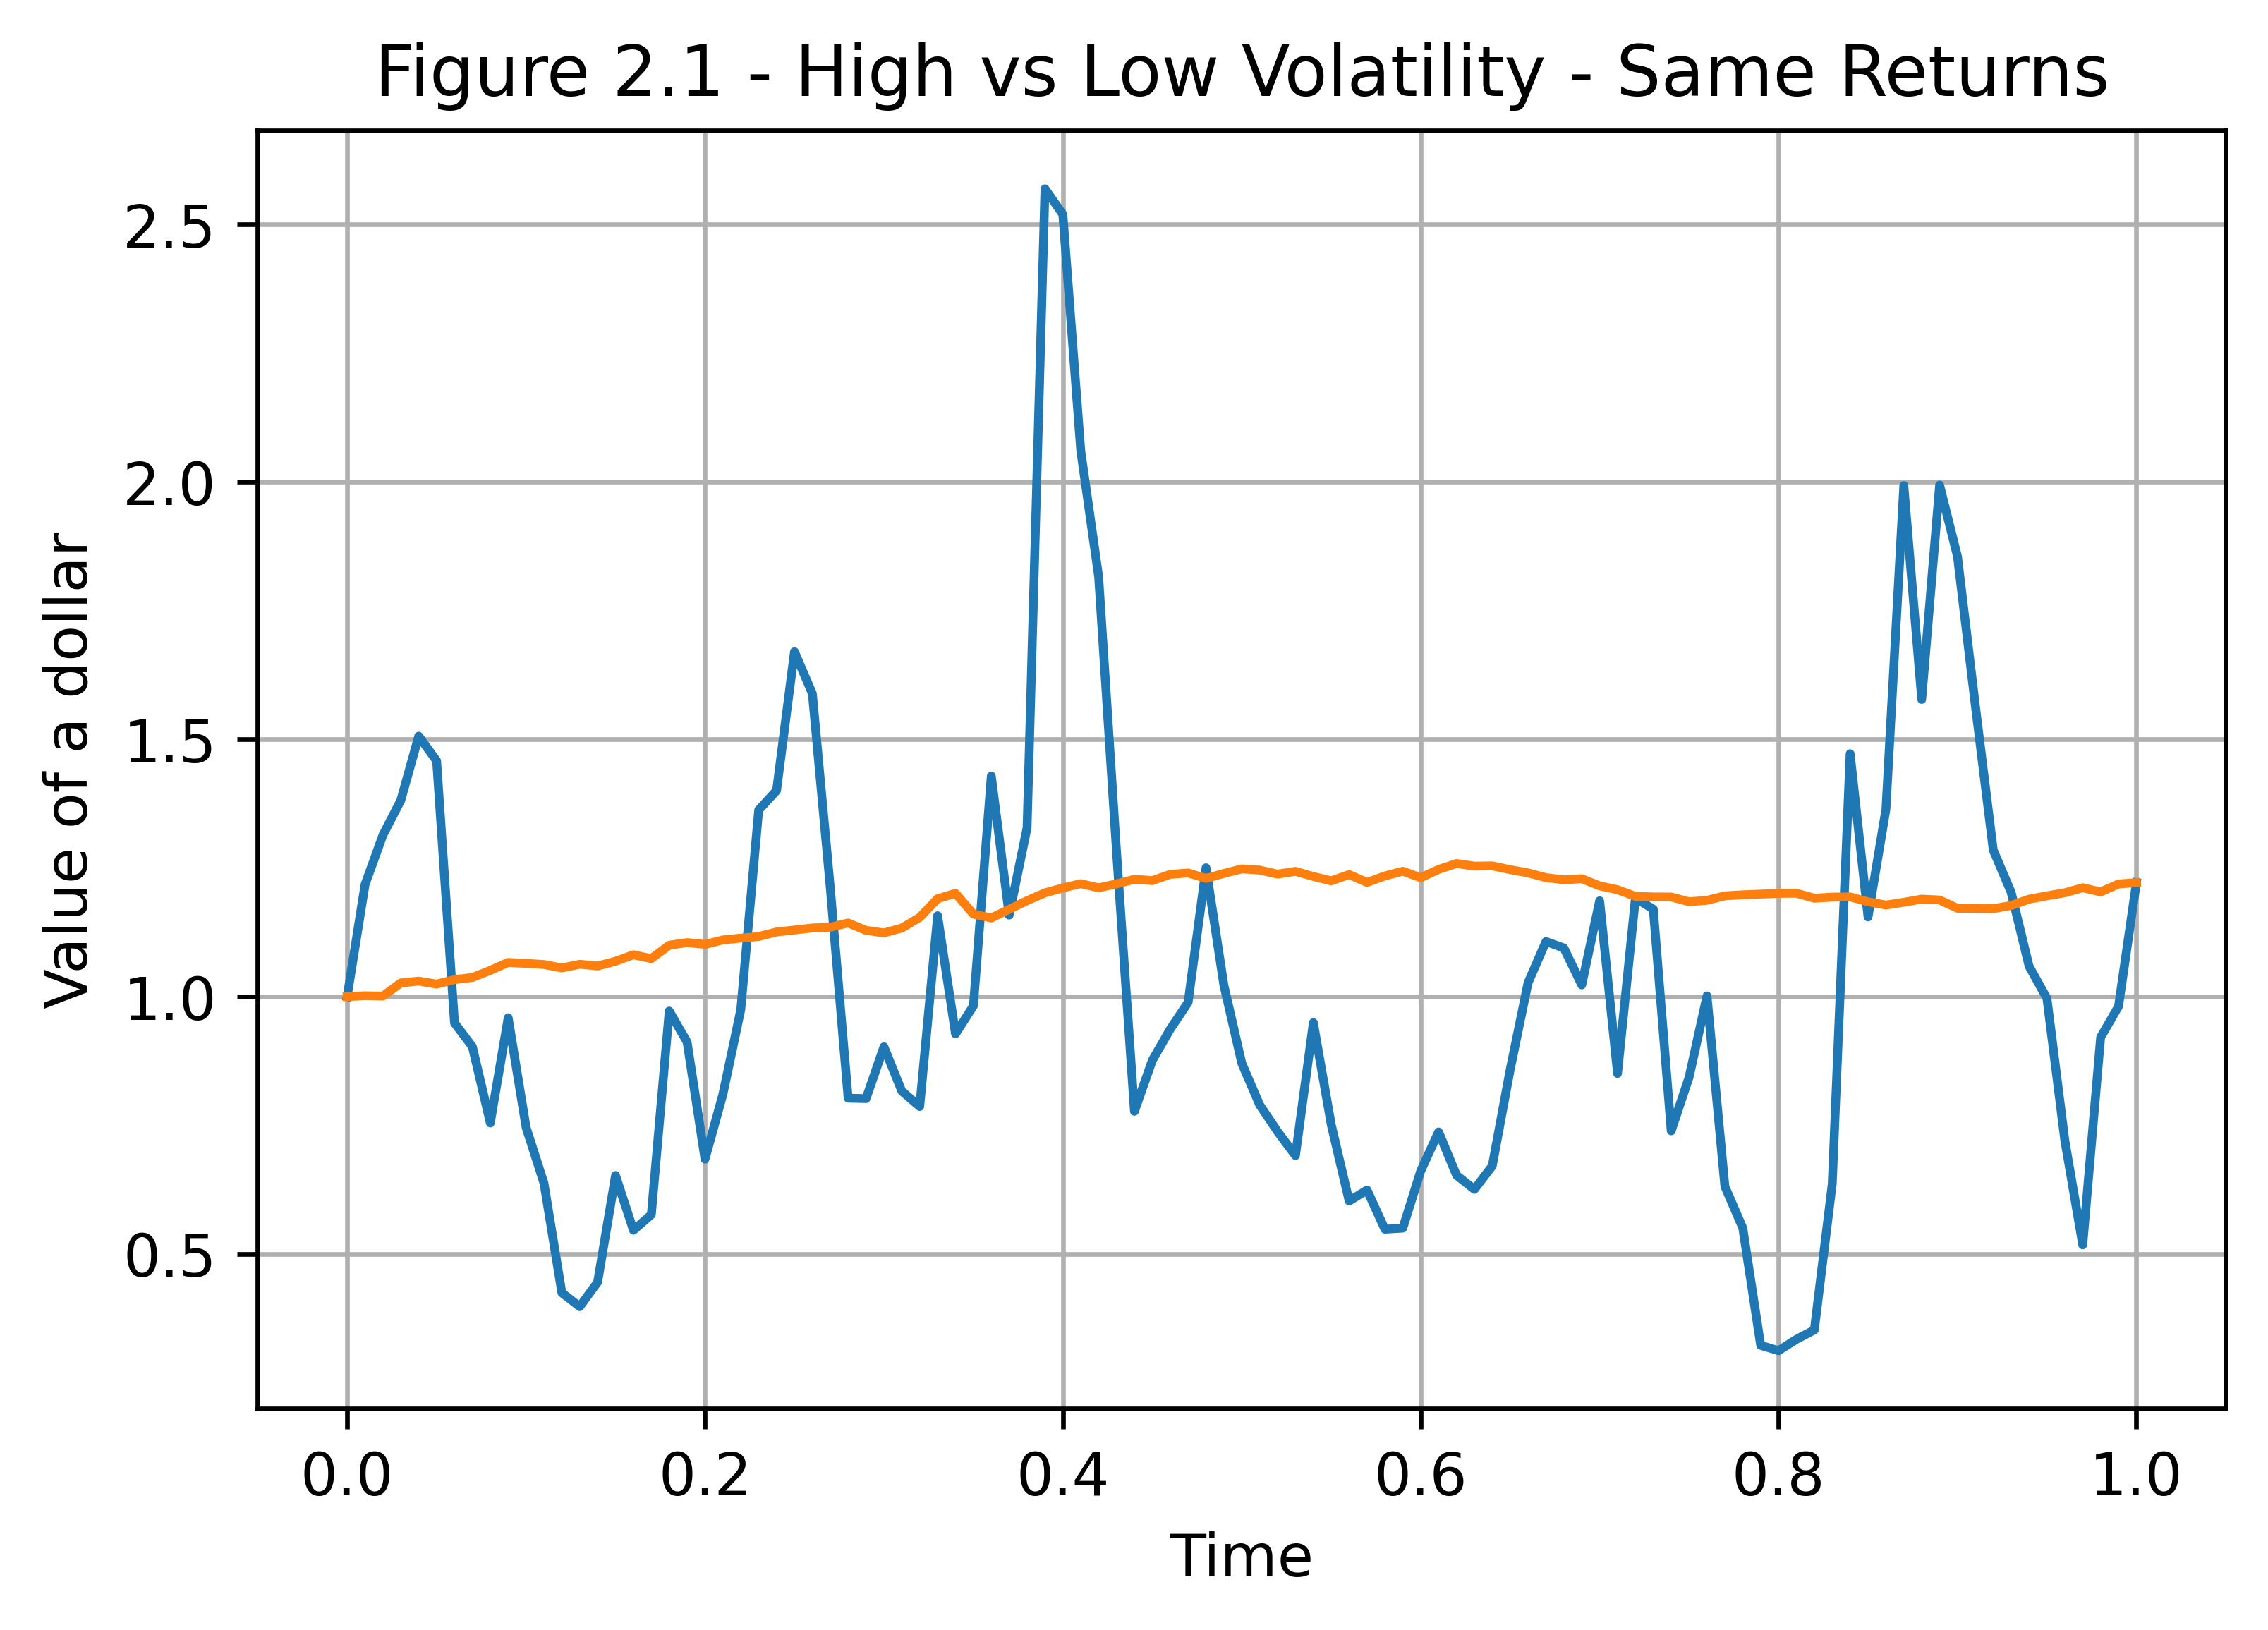

In [2]:
#Generate a high volatility and a low volatility price series
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']= 300

x=np.arange(0,1.01,.01)
rng = np.random.default_rng(27182818)   #Use seed so repeatable
r1=rng.normal(loc=0.,scale=.3,size=100)
r2=rng.normal(loc=0.,scale=.01,size=100)
#Force both series to end up in the same place
r1+=.002-np.average(r1)
r2+=.002-np.average(r2)
#Start both series at a value of 1 and
#switch from log(pnew/pold-1) to pnew/pold-1
y1=np.append(np.array(1),np.exp(np.cumsum(r1)))
y2=np.append(np.array(1),np.exp(np.cumsum(r2)))
plt.title("Figure 2.1 - High vs Low Volatility - Same Returns")
plt.xlabel('Time')
plt.ylabel('Value of a dollar')
plt.grid()
plt.plot(x,y1)
plt.plot(x,y2);

Code segment 2.2  
Figure 2.2 in Section 2.3.1

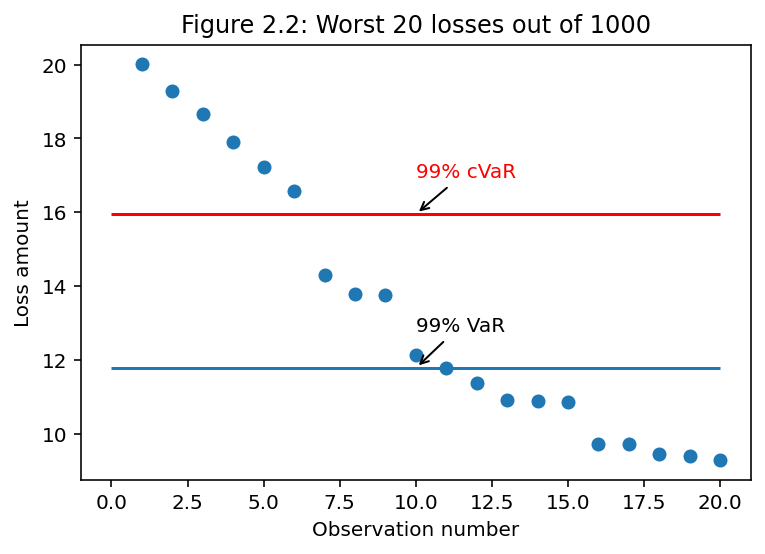

99% VaR is  11.781890699024686
99% cVaR is  15.949993320207135
99% interpolated VaR is  12.12450571944469
99% interpolated cVaR is  16.3625655225223


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as spst

#Generate some random numbers and show VaR and cVaR

#Generate 90% low vol, 10% high vol random numbers; this creates a fat-tailed distribution
trials=1000
rng = np.random.default_rng(314159)   #Use seed so repeatable
y=np.concatenate((rng.normal(0.,1.,int(.9*trials)), \
                  rng.normal(0.,10.,int(.1*trials))))
y.sort()  #Put them in order

p=.99
p100=p*100.
p_string="%0.0f"% p100

# Compute sample p-VaR; n=trials
# We assume there is probability mass = 1/(n+1) at each of the n observations.
# So the smallest observation has cumulative probability mass 1/(n+1) and
# the largest observation has cumulative probability mass n/(n+1)
# From (2.4) we want the smallest k such that
# k/(n+1) >= 1-p, i.e. k>=(n+1)(1-p)

breakpoint=(trials+1)*(1-p)
k=int(breakpoint)
#Python list convention is: first list element is index 0
#So if breakpoint is an integer, decrement k
#Otherwise leave it alone to get the next one up
if k==breakpoint:
    k-=1
VaRp=-y[k]

#Compute cVaR
#Standardization factor is (sum of probabilities <= VaRp). Here that's (k+1)/(n+1).
#As n->infinity that will get closer and closer to 1-p, but for the finite case
#it's a little off.
cVaRp=-np.sum(y[:k+1])/(k+1)

plt.scatter(range(1,21),-y[:20])
plt.annotate(p_string+"% VaR", xy=(10.0, VaRp), xytext=(10.0, VaRp+1),
            arrowprops=dict(arrowstyle='->',
                    facecolor='black'))
plt.hlines(VaRp,0,20)

plt.annotate(p_string+"% cVaR", xy=(10.0, cVaRp), xytext=(10.0, cVaRp+1),
            color='red', arrowprops=dict(arrowstyle='->',
                    facecolor='red'))
plt.hlines(cVaRp,0,20,colors='red')

plt.title('Figure 2.2: Worst 20 losses out of '+str(trials))
plt.xlabel('Observation number')
plt.ylabel('Loss amount')
plt.show();

pv_string=p_string+"% VaR is "
print(pv_string,VaRp)
pcv_string=p_string+"% cVaR is "
print(pcv_string,cVaRp)

#For comparison, generate VaR and cVaR with interpolation
#numpy percentile function does the wrong thing - assumes first observation
#is 0 percentile and last is 100th. Cure that by adding extra observations
#at each end.
z=np.insert(y,0,y[0]-1)
z=np.append(z,z[-1]+1)
VaRp_interp=-np.percentile(z,(1-p)*100)
# Compute sample p-cVaR without interpolation
nexceed=max(np.where(y<=-VaRp_interp)[0])
#-VaRp is (1-p) of the way between y[nexceed] and y[nexceed+1]
cVaRp_interp=-(np.sum([yy for yy in y if yy<=-VaRp_interp])-(1-p)*VaRp_interp)/ \
    (nexceed+2-p)
pv_string=p_string+"% interpolated VaR is "
print(pv_string,VaRp_interp)
pcv_string=p_string+"% interpolated cVaR is "
print(pcv_string,cVaRp_interp)

Code segment 2.3  
Calculation in Section 2.3.1

In [4]:
#Get mean and standard deviation of the data
samp_mean=np.mean(y)
samp_std=np.std(y)

#Show normal VaR vs sample VaR
nVaRp=-(samp_mean+samp_std*spst.norm.ppf(1-p))
pv_string=p_string+"% Sample VaR is "
print(pv_string,VaRp)
pvn_string=p_string+"% Normal VaR is "
print(pvn_string,nVaRp)

# Get normal cVaR
ncVaRp=-samp_mean+samp_std*np.exp(-.5*(nVaRp/samp_std)**2)/((1-p)*np.sqrt(2*np.pi))
pcv_string=p_string+"% Sample cVaR is "
print(pcv_string,cVaRp)
pncv_string=p_string+"% Normal cVaR is "
print(pncv_string,ncVaRp)

99% Sample VaR is  11.781890699024686
99% Normal VaR is  7.5958778057456735
99% Sample cVaR is  15.949993320207135
99% Normal cVaR is  8.43350174708078


Code segment 2.4  
Figure 2.3 in Section 2.6

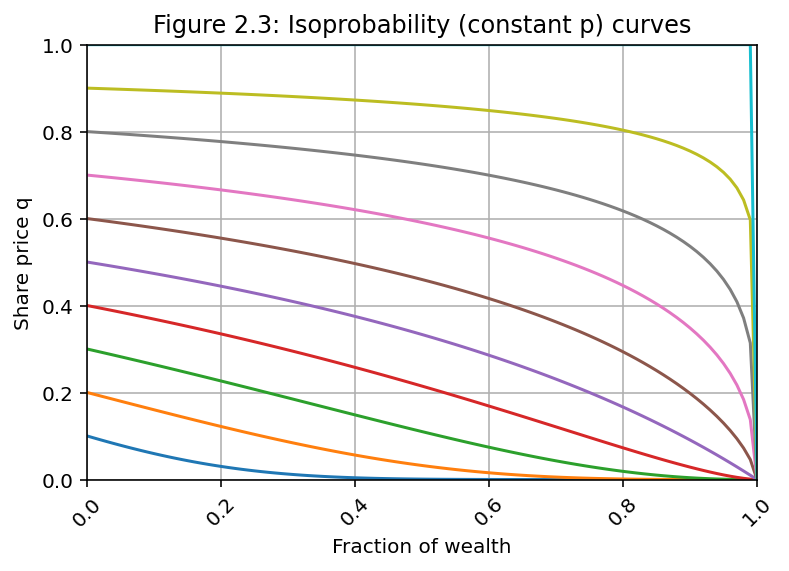

In [5]:
def SharePrice(f,p):
    #Price to pay when a fraction f of
    #wealth is invested in a gamble that pays 1 with probability
    #p and 0 otherwise, log-utility
    #See formula 2.16 above
    if (f<0) or (f>=1) or (p<=0) or (p>1): #Can't bet anything
        return(0.0)
    if (f==0.0):              #Limiting amount to be risk-neutral
        return(p)
    if (p==1.0):
        return(1.0)
    one_minus_f=1-f
    denom=one_minus_f**(1-1/p)-one_minus_f
    return(f/denom)
#Done with SharePrice

#Generate isoprobability graphs

frac_wealth = np.arange(0,1.01,.01) #compute at fractions of wealth
                                    #ranging from 0 to 1 by .01's
prob = np.arange(.1,1.1,.1) #Compute isoprobability curves every 10%
                            #of probability
#y is a list of lists - each contained list is an isoprobability curve
y=[[SharePrice(fw,pr) for fw in frac_wealth] for pr in prob]

#Display the graph
for i in range(len(prob)):    #Do each isoprobability line
    plt.plot(frac_wealth,y[i])

plt.xticks(rotation=45)
plt.grid()
plt.title('Figure 2.3: Isoprobability (constant p) curves')
plt.xlabel('Fraction of wealth')
plt.ylabel('Share price q')
plt.axis([0,1,0,1])
plt.show();

Code segment 2.5  
Figure 2.4 in Section 2.7.2

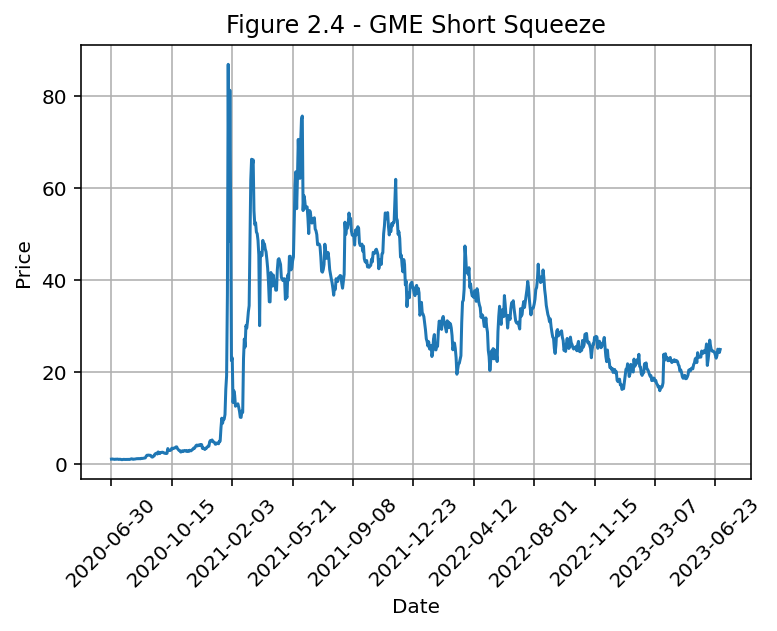

In [6]:
#Display GME short squeeze 2020-
import yfinance as yf
from datetime import datetime

tix = yf.Ticker("GME")
# get historical market data
hist = tix.history(period="max")

#Drop rows with any NaNs
hist = hist.dropna()

#Plot prices
start_date = datetime.strptime("2020-06-30", "%Y-%m-%d")
x=[]; y=[]
for i in range(len(hist.index)):
    hi_date=hist.index[i].to_pydatetime().replace(tzinfo=None)
    if hi_date>=start_date:
        x.append(hist.index[i].strftime("%Y-%m-%d"))           #dates
        y.append(hist.Close[i])                                #adjusted prices
i=np.arange(len(y))   #index
plt.plot(i,y)

#Display about 10 dates on the x axis
stride=int(len(y)/10)
plt.xticks(i[::stride],x[::stride],rotation=45)

plt.title("Figure 2.4 - GME Short Squeeze")
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show();